# LC3 DATA ANALYSIS

In this notebook we analize the relation of the compressive strength of LC3 with the clay used for its elaboration properties. For this purpose we utilize the dataset given by the Constructions Materials Laboratory at EPFL. This dataset consists of different measures of compressive strength for different types of LC3 cement in which the clay used for their ellaboration varies. We have also several clay properties measured and the objetive is finding the relation of the compressive strength (CS) with these for a deeper understanding of key elements in LC3 cement.

### Load libraries and data

In [1]:
from lc3_implementations import *

In [2]:
# Input file path (can be also an excel)
DATA_MERGED_PATH = './data/data_merged.ods'
DATA_FULL_PATH   = './data/data_full.ods'

In [3]:
# Read full data and remove empty lines
data_full = pd.read_excel(DATA_FULL_PATH,sheet_name='Clays_CS',na_values=['-'])
data_full.dropna(how="all", inplace=True)

In [4]:
# Read clay properties
data_clay   = pd.read_excel(DATA_FULL_PATH,sheet_name='Clays_properties', na_values=['-'])

In [5]:
# Merge to have the whole dataset
data_full_clay = pd.merge(data_full, data_clay, left_on='Clay', right_on='Clay', how='left')

In [8]:
# We rename some columns for having an easier reference
rename_cols(data_full_clay)

### Visualize data

In [9]:
# Take kaolinite content
x = data_full_clay['Kaolinite_content'].values

# Take compression strengths
y1  = data_full_clay[ "day_1"].values
y3  = data_full_clay[ "day_3"].values
y7  = data_full_clay[ "day_7"].values
y28 = data_full_clay["day_28"].values
y90 = data_full_clay["day_90"].values

# Measures have missing values
x1 =   x[np.logical_not(np.isnan(y1))]
y1 = y1[np.logical_not(np.isnan(y1))]
x3 =   x[np.logical_not(np.isnan(y3))]
y3 = y3[np.logical_not(np.isnan(y3))]
x7 =   x[np.logical_not(np.isnan(y7))]
y7 = y7[np.logical_not(np.isnan(y7))]
x28 =   x[np.logical_not(np.isnan(y28))]
y28 = y28[np.logical_not(np.isnan(y28))]
x90 =   x[np.logical_not(np.isnan(y90))]
y90 = y90[np.logical_not(np.isnan(y90))]

# Take standard deviations
#z1  = data[ "STD_1D"].values
#z3  = data[ "STD_3D"].values
#z7  = data[ "STD_7D"].values
#z28 = data["STD_28D"].values
#z90 = data["STD_90D"].values

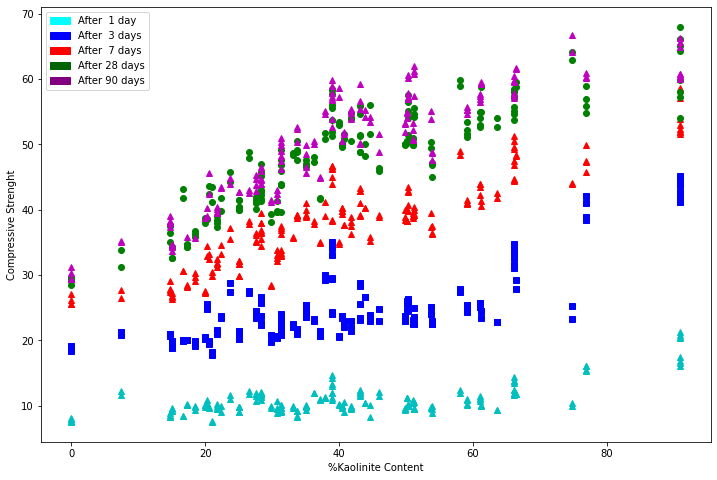

In [10]:
# Show points using matplotlib.pyplot library
fig, ax = plt.subplots(figsize=(12, 8))
plt.plot(x1,y1,'c^',x3,y3,'bs',x7,y7,'r^',x28,y28,'go', x90,y90,'m^' )
plt.xlabel('%Kaolinite Content')
plt.ylabel('Compressive Strenght')

d1_patch  = mpatches.Patch(color='cyan',      label='After  1 day')
d3_patch  = mpatches.Patch(color='blue',      label='After  3 days')
d7_patch  = mpatches.Patch(color='red',       label='After  7 days')
d28_patch = mpatches.Patch(color='darkgreen', label='After 28 days')
d90_patch = mpatches.Patch(color='purple',    label='After 90 days')
plt.legend(handles=[d1_patch,d3_patch,d7_patch,d28_patch,d90_patch])

plt.show()

# COMPRESSION STRENGTH (CS)

### Linear regression models

We have seen that the kaolinite content is the most predictive feature that we have. We are going to start creating simple linear regression models and then, following the appreciations obtained by visualizing the data, we are going to create non-linear models based on the kaolinite content for better fitting the data distribution as well as models with more features for avoiding data sparsification.

Two metrics are going to be extremely important here:
* **R square:** Is giving us a measurement of how good is our model (the closer to 1.0 the better). 
* **Validation score:** Is going to let us control overfitting. Improving R² means nothing if validation is worse. We'll use mean squared error with Leave One Out cross validation to estimate it.

In [9]:
# TODO: Remove outlier in y1 data?
# TODO: Idea for the report, removing pesimist outliers is not a good idea in our project!
# DONE # TODO: Add OPC compression strength values for reference

#### Linear models based on the kaolinite content

f(x) = 7.757071248182706 + 0.07675459691387533*x


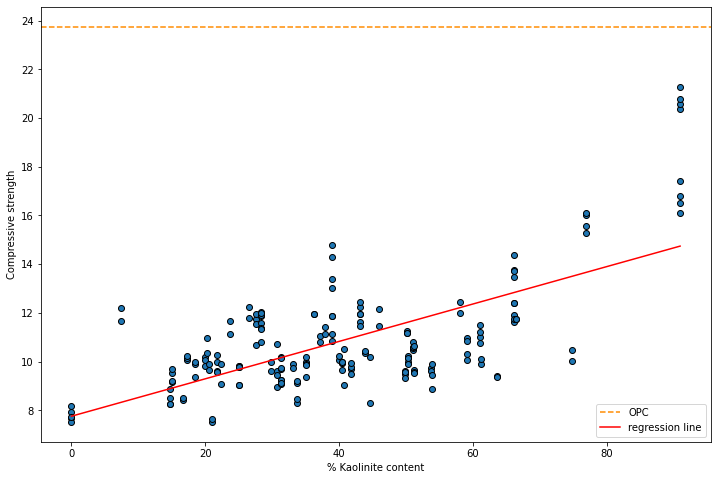

MSE: 2.998686102097349
R^2: 0.45106283702868666


In [10]:
leave_one_out_validation(x1.reshape(-1,1), y1, 1)

f(x) = 16.11138281681658 + 0.22028582288371565*x


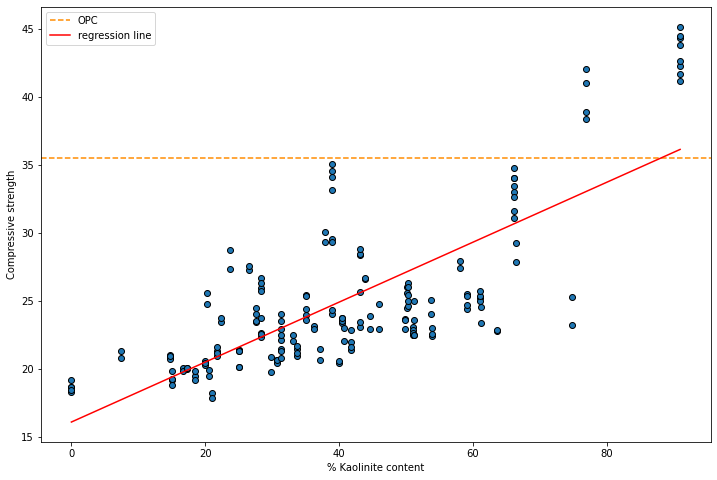

MSE: 14.304219475415978
R^2: 0.5850161286666817


In [11]:
leave_one_out_validation(x3.reshape(-1,1), y3, 3)

f(x) = 25.72491386854514 + 0.3039226286708796*x


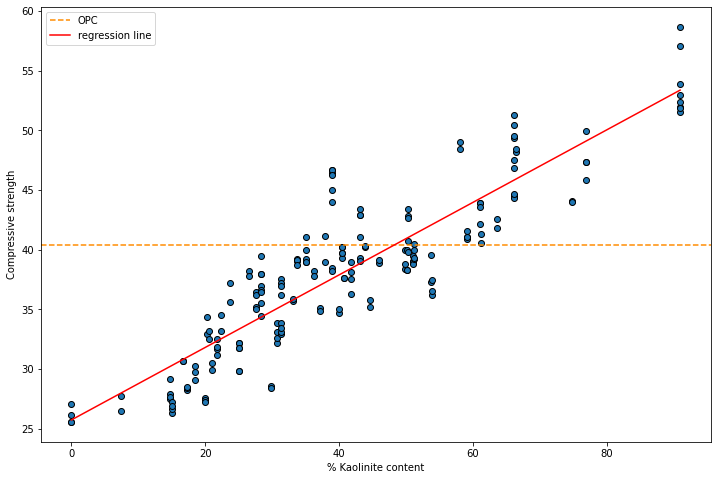

MSE: 9.22695612206208
R^2: 0.8021815770299499


In [12]:
leave_one_out_validation(x7.reshape(-1,1), y7, 7)

f(x) = 33.32503170252927 + 0.3564569705862277*x


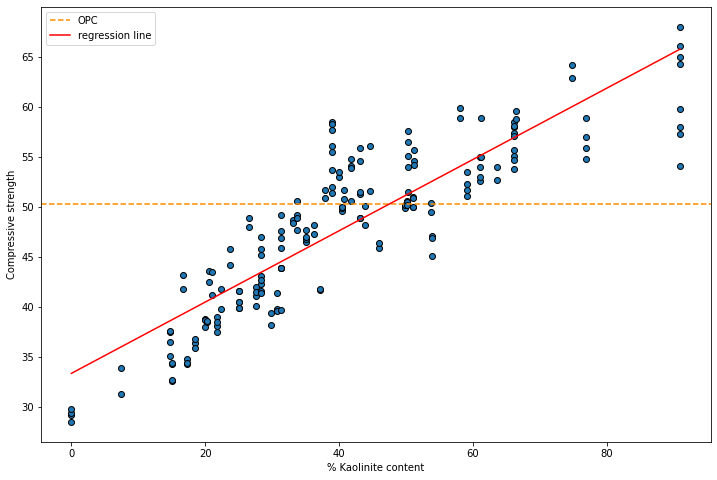

MSE: 15.533889722852303
R^2: 0.7708551476800288


In [13]:
leave_one_out_validation(x28.reshape(-1,1), y28, 28)

f(x) = 34.72008248475339 + 0.37713645868389345*x


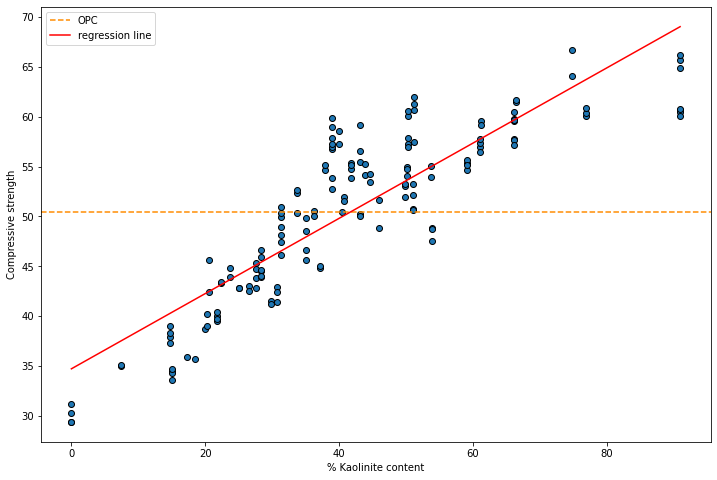

MSE: 16.961885470992808
R^2: 0.7765446687129038


In [14]:
leave_one_out_validation(x90.reshape(-1,1), y90, 90)

**First sight analysis:**

* There is few more we can improve at the 7th day using only the kaolinite content, data distribution is quite a straight line.
* For 1st and 3rd day the problem is more the sparsification of the points than the lack of expresivity of the model.
* For 28th and 90th day until 40% of kaolinite content the compression strength increases linearly and then estabilizes. Makes sense a non-linear model.
* It doesn't make sense in any model a degree 3 regression model, compression strength increases with kaolinite content.

#### Non-linear models based on the kaolinite content

In [15]:
# x_2 = Kaolinite content, (Kaolinite content)^2
x1_2   = np.array([x1, x1**2]).T
x3_2   = np.array([x3, x3**2]).T
x7_2   = np.array([x7, x7**2]).T
x28_2   = np.array([x28, x28**2]).T
x90_2 = np.array([x90,x90*x90]).T 

f(x) = 10.310550266313655 + -0.06317775324896209*x + 0.0015247208198673212*x^2


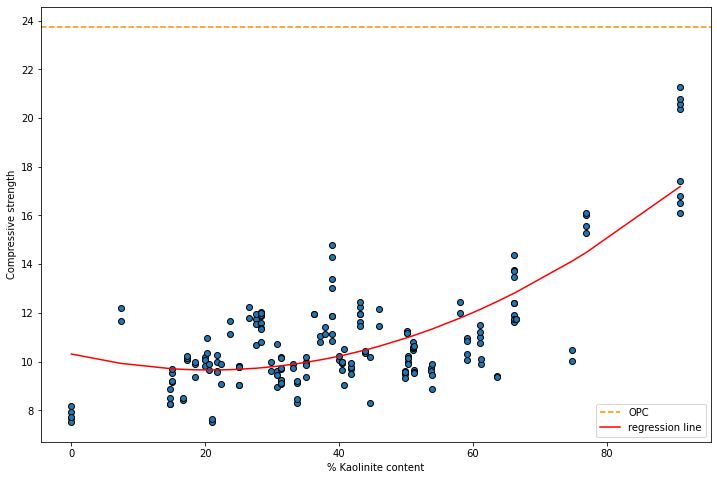

MSE: 2.335067644384823
R^2: 0.5802361848393611


In [16]:
leave_one_out_validation(x1_2, y1, 1)

f(x) = 21.499593836099045 + -0.07517428017416158*x + 0.003217313075448703*x^2


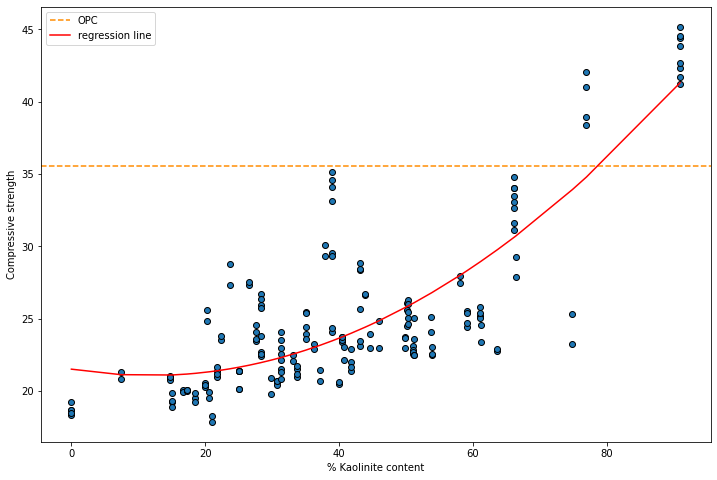

MSE: 11.161599829779187
R^2: 0.6761941738185395


In [17]:
leave_one_out_validation(x3_2, y3, 3)

f(x) = 24.622228848517516 + 0.3633448897361721*x + -0.0006406772264533244*x^2


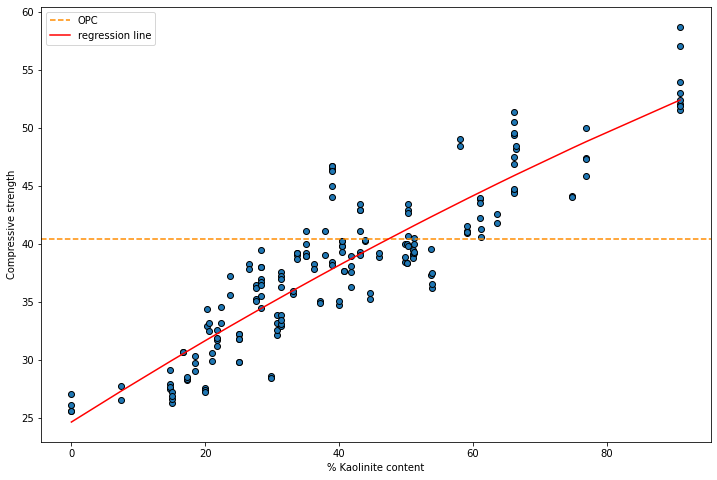

MSE: 9.199436032207917
R^2: 0.8046818970628405


In [18]:
leave_one_out_validation(x7_2, y7, 7)

f(x) = 27.502120699429362 + 0.6708050880810226*x + -0.003387953141111517*x^2


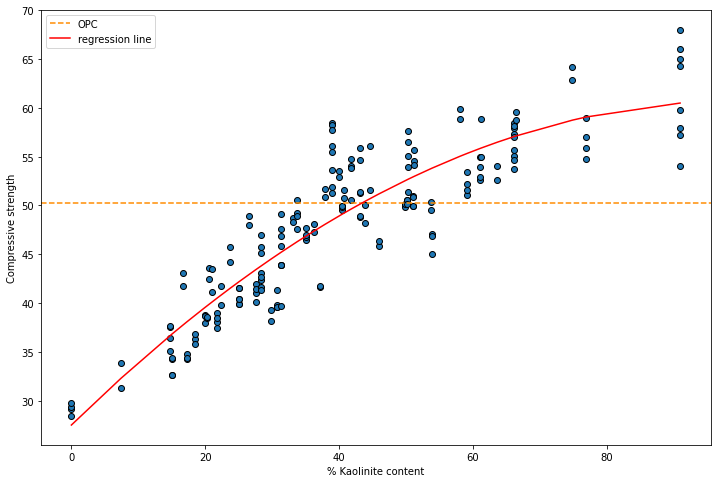

MSE: 12.368760880897872
R^2: 0.8195507057666824


In [19]:
leave_one_out_validation(x28_2, y28, 28)

f(x) = 27.49766314037669 + 0.7660694480966836*x + -0.0042039181629022655*x^2


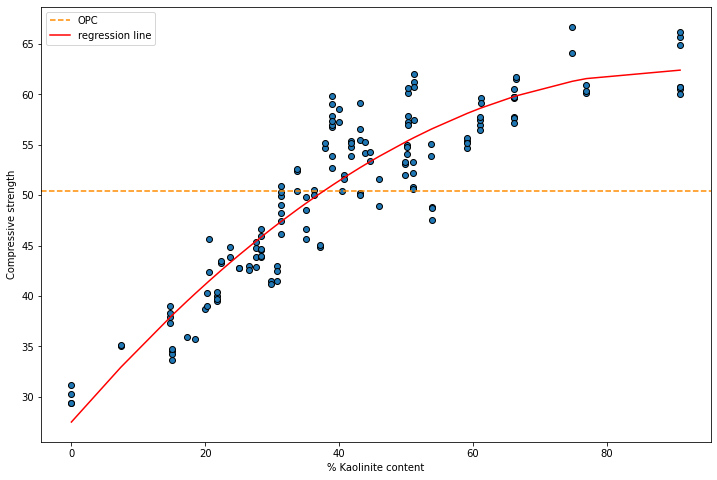

MSE: 11.407070054088853
R^2: 0.8500509643195537


In [20]:
leave_one_out_validation(x90_2, y90, 90)

**First sight analysis:**

* Expected results, better models obtained for 28th and 90th day compression strength obtained.
* We might be experiencing overfitting with this model for 1st and 3rd day measurements because we're not increasing the compressive strength with the increase of calonita for small contents.

### Feature selection

In [21]:
#DONE#### TODO: Dummy issue, we have generalized feature selection function but in one dataset days ar "7D" and in the other days are "day_7"

In [28]:
data_full_clay.columns

Index(['Clay', 'day_1', 'day_3', 'day_7', 'day_28', 'day_90', 'Origin of clay',
       'Calcination', 'Kaolinite_content', 'Dv50', 'D10', 'D90', 'span',
       'BET_specific_surface', 'SiO2', 'Al2O3', 'Fe2O3', 'CaO', 'MgO', 'SO3',
       'Na2O', 'K2O', 'TiO2', 'P2O5', 'MnO', 'Others', 'LOI'],
      dtype='object')

In [29]:
# Which features are realiable? Those with more than RELIABLE_THRESHOLD measurements
RELIABLE_THRESHOLD = 45

features = data_full_clay.columns[9:]
reliable_features = [f for f in features if data_full_clay[f].describe()[0] >= RELIABLE_THRESHOLD]

In [22]:
# Show the reliable features, with enough points to rely
#reliable_features

Highlight maximums of R2 in color Red and minimums of MSE in color green.

In [30]:
feature_selection(data_full_clay,reliable_features)
#feature_selection(features)

,day_1_mse,day_1_adjR2,day_3_mse,day_3_adjR2,day_7_mse,day_7_adjR2,day_28_mse,day_28_adjR2,day_90_mse,day_90_adjR2
Dv50,2.523652,0.625144,11.918247,0.703561,8.846999,0.813552,13.280057,0.802791,11.949038,0.840459
D10,1.939895,0.774293,6.334905,0.871561,6.435486,0.884293,9.387591,0.885209,8.526930,0.904957
D90,2.033465,0.762400,6.435508,0.868937,5.851973,0.895640,8.880808,0.891324,8.492349,0.906792
span,2.536368,0.623188,11.394491,0.716454,8.569477,0.819256,13.584905,0.798614,12.207367,0.838529
BET_specific_surface,2.578740,0.629238,11.229050,0.730783,8.845458,0.824815,12.590188,0.827027,10.505894,0.869053
SiO2,2.664197,0.563248,12.612941,0.655471,8.712382,0.808445,12.347313,0.816490,10.638031,0.855960
Al2O3,2.364751,0.598083,12.415825,0.654932,9.792095,0.768346,13.787037,0.764693,11.772939,0.812422
Fe2O3,2.369099,0.595883,12.246906,0.659802,9.494415,0.775548,12.986437,0.779012,11.057393,0.824863
CaO,1.561649,0.083825,8.899963,0.173236,9.177589,0.671910,15.258490,0.715825,14.151221,0.769223
MgO,1.975983,0.216186,12.045010,0.350110,8.462969,0.702992,13.147284,0.730525,11.584294,0.797212


#### Linear regression models based on the kaolinite content and other features

Following the results obtained in the feature selection part, here we are creating and analyzing the models done with the kaolinite conent (in degree one and two) as well as other feature.

In [25]:
#DONEEE### TODO: Same issue than in feature selection, unify days names in both datasets!
#TODO: Entiendo que habrá que poner las caracteristicas que correpondan para cada día, de acuerdo a los colores

In [11]:
# Day 1
get_model_summary(create_r_formula(1,'Dv50'),get_model_data(data_full_clay, 'Dv50','day_1'))

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  day_1   R-squared:                       0.633
Model:                            OLS   Adj. R-squared:                  0.625
Method:                 Least Squares   F-statistic:                     81.05
Date:                Sat, 12 Dec 2020   Prob (F-statistic):           1.56e-30
Time:                        08:20:52   Log-Likelihood:                -267.81
No. Observations:                 145   AIC:                             543.6
Df Residuals:                     141   BIC:                             555.5
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
============================================================================================
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
Intercept                   10.1359      0.582     17.420      0.000       8.986      11.286
Kaolinite_content           -0.0431      0.022     -1.939      0.055      -0.087       0.001
Kaolinite_content_square     0.0014      0.000      6.088      0.000       0.001       0.002
Dv50                        -0.0249      0.021     -1.184      0.238      -0.067       0.017
==============================================================================
Omnibus:                        4.992   Durbin-Watson:                   0.640
Prob(Omnibus):                  0.082   Jarque-Bera (JB):                4.961
Skew:                           0.452   Prob(JB):                       0.0837
Kurtosis:                       2.933   Cond. No.                     1.36e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.36e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [12]:
# Day 1
get_model_summary(create_r_formula(1,'CaO'),get_model_data(data_full_clay, 'CaO','day_1'))

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  day_1   R-squared:                       0.106
Model:                            OLS   Adj. R-squared:                  0.084
Method:                 Least Squares   F-statistic:                     4.782
Date:                Sat, 12 Dec 2020   Prob (F-statistic):            0.00348
Time:                        08:21:14   Log-Likelihood:                -200.64
No. Observations:                 125   AIC:                             409.3
Df Residuals:                     121   BIC:                             420.6
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
============================================================================================
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
Intercept                    9.0308      0.664     13.594      0.000       7.716      10.346
Kaolinite_content            0.0671      0.034      1.960      0.052      -0.001       0.135
Kaolinite_content_square    -0.0007      0.000     -1.565      0.120      -0.001       0.000
CaO                         -0.1346      0.062     -2.164      0.032      -0.258      -0.011
==============================================================================
Omnibus:                       13.913   Durbin-Watson:                   0.877
Prob(Omnibus):                  0.001   Jarque-Bera (JB):               15.190
Skew:                           0.750   Prob(JB):                     0.000503
Kurtosis:                       3.817   Cond. No.                     1.27e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.27e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [13]:
# Day 3
get_model_summary(create_r_formula(3,'Dv50'),get_model_data(data_full_clay, 'Dv50','day_3'))

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  day_3   R-squared:                       0.710
Model:                            OLS   Adj. R-squared:                  0.704
Method:                 Least Squares   F-statistic:                     114.1
Date:                Sat, 12 Dec 2020   Prob (F-statistic):           1.97e-37
Time:                        08:21:32   Log-Likelihood:                -379.55
No. Observations:                 144   AIC:                             767.1
Df Residuals:                     140   BIC:                             779.0
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
============================================================================================
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
Intercept                   20.9810      1.281     16.383      0.000      18.449      23.513
Kaolinite_content           -0.0794      0.049     -1.620      0.107      -0.176       0.017
Kaolinite_content_square     0.0034      0.000      6.831      0.000       0.002       0.004
Dv50                         0.0558      0.046      1.202      0.231      -0.036       0.147
==============================================================================
Omnibus:                       20.800   Durbin-Watson:                   0.641
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               25.980
Skew:                           0.869   Prob(JB):                     2.28e-06
Kurtosis:                       4.145   Cond. No.                     1.35e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.35e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [14]:
# Day 3
get_model_summary(create_r_formula(3,'CaO'),get_model_data(data_full_clay, 'CaO','day_3'))

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  day_3   R-squared:                       0.193
Model:                            OLS   Adj. R-squared:                  0.173
Method:                 Least Squares   F-statistic:                     9.661
Date:                Sat, 12 Dec 2020   Prob (F-statistic):           9.15e-06
Time:                        08:21:53   Log-Likelihood:                -311.34
No. Observations:                 125   AIC:                             630.7
Df Residuals:                     121   BIC:                             642.0
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
============================================================================================
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
Intercept                   17.5456      1.611     10.893      0.000      14.357      20.734
Kaolinite_content            0.2763      0.083      3.329      0.001       0.112       0.441
Kaolinite_content_square    -0.0025      0.001     -2.451      0.016      -0.005      -0.000
CaO                         -0.1467      0.151     -0.973      0.333      -0.445       0.152
==============================================================================
Omnibus:                       38.018   Durbin-Watson:                   0.631
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               66.456
Skew:                           1.390   Prob(JB):                     3.71e-15
Kurtosis:                       5.242   Cond. No.                     1.27e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.27e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [15]:
# Day 7
get_model_summary(create_r_formula(7,'BET_specific_surface'),get_model_data(data_full_clay, 'BET_specific_surface','day_7'))

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  day_7   R-squared:                       0.829
Model:                            OLS   Adj. R-squared:                  0.825
Method:                 Least Squares   F-statistic:                     217.6
Date:                Sat, 12 Dec 2020   Prob (F-statistic):           1.66e-51
Time:                        08:23:46   Log-Likelihood:                -345.33
No. Observations:                 139   AIC:                             698.7
Df Residuals:                     135   BIC:                             710.4
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
============================================================================================
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
Intercept                   25.1170      0.937     26.812      0.000      23.264      26.970
Kaolinite_content            0.3910      0.045      8.634      0.000       0.301       0.481
Kaolinite_content_square    -0.0009      0.000     -2.009      0.047      -0.002   -1.43e-05
BET_specific_surface        -0.0223      0.017     -1.275      0.205      -0.057       0.012
==============================================================================
Omnibus:                        7.108   Durbin-Watson:                   0.768
Prob(Omnibus):                  0.029   Jarque-Bera (JB):                7.359
Skew:                           0.561   Prob(JB):                       0.0252
Kurtosis:                       2.885   Cond. No.                     1.12e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.12e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [16]:
# Day 7
get_model_summary(create_r_formula(7,'span'),get_model_data(data_full_clay, 'span','day_7'))

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  day_7   R-squared:                       0.823
Model:                            OLS   Adj. R-squared:                  0.819
Method:                 Least Squares   F-statistic:                     217.1
Date:                Sat, 12 Dec 2020   Prob (F-statistic):           1.93e-52
Time:                        08:24:07   Log-Likelihood:                -355.81
No. Observations:                 144   AIC:                             719.6
Df Residuals:                     140   BIC:                             731.5
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
============================================================================================
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
Intercept                   24.7194      0.996     24.829      0.000      22.751      26.688
Kaolinite_content            0.3099      0.045      6.927      0.000       0.221       0.398
Kaolinite_content_square    -0.0002      0.000     -0.387      0.699      -0.001       0.001
span                         0.2950      0.093      3.186      0.002       0.112       0.478
==============================================================================
Omnibus:                       13.607   Durbin-Watson:                   0.833
Prob(Omnibus):                  0.001   Jarque-Bera (JB):               15.065
Skew:                           0.663   Prob(JB):                     0.000536
Kurtosis:                       3.866   Cond. No.                     1.25e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.25e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [17]:
# Day 28
get_model_summary(create_r_formula(28,'BET_specific_surface'),get_model_data(data_full_clay, 'BET_specific_surface','day_28'))

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 day_28   R-squared:                       0.831
Model:                            OLS   Adj. R-squared:                  0.827
Method:                 Least Squares   F-statistic:                     217.7
Date:                Sat, 12 Dec 2020   Prob (F-statistic):           4.06e-51
Time:                        08:24:25   Log-Likelihood:                -363.72
No. Observations:                 137   AIC:                             735.4
Df Residuals:                     133   BIC:                             747.1
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
============================================================================================
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
Intercept                   27.7510      1.113     24.942      0.000      25.550      29.952
Kaolinite_content            0.7273      0.054     13.451      0.000       0.620       0.834
Kaolinite_content_square    -0.0040      0.001     -7.364      0.000      -0.005      -0.003
BET_specific_surface        -0.0345      0.021     -1.657      0.100      -0.076       0.007
==============================================================================
Omnibus:                        2.107   Durbin-Watson:                   0.841
Prob(Omnibus):                  0.349   Jarque-Bera (JB):                2.086
Skew:                           0.240   Prob(JB):                        0.352
Kurtosis:                       2.631   Cond. No.                     1.12e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.12e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [18]:
# Day 28
get_model_summary(create_r_formula(28,'TiO2'),get_model_data(data_full_clay, 'TiO2','day_28'))

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 day_28   R-squared:                       0.777
Model:                            OLS   Adj. R-squared:                  0.773
Method:                 Least Squares   F-statistic:                     174.5
Date:                Sat, 12 Dec 2020   Prob (F-statistic):           1.05e-48
Time:                        08:24:49   Log-Likelihood:                -414.83
No. Observations:                 154   AIC:                             837.7
Df Residuals:                     150   BIC:                             849.8
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
============================================================================================
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
Intercept                   27.0501      1.497     18.069      0.000      24.092      30.008
Kaolinite_content            0.6591      0.063     10.462      0.000       0.535       0.784
Kaolinite_content_square    -0.0035      0.001     -5.576      0.000      -0.005      -0.002
TiO2                         0.9201      0.433      2.124      0.035       0.064       1.776
==============================================================================
Omnibus:                        3.515   Durbin-Watson:                   0.837
Prob(Omnibus):                  0.173   Jarque-Bera (JB):                3.559
Skew:                           0.359   Prob(JB):                        0.169
Kurtosis:                       2.800   Cond. No.                     1.57e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.57e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [20]:
# Day 90
get_model_summary(create_r_formula(90,'BET_specific_surface'),get_model_data(data_full_clay, 'BET_specific_surface','day_90'))

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 day_90   R-squared:                       0.872
Model:                            OLS   Adj. R-squared:                  0.869
Method:                 Least Squares   F-statistic:                     266.5
Date:                Sat, 12 Dec 2020   Prob (F-statistic):           4.14e-52
Time:                        08:25:47   Log-Likelihood:                -310.56
No. Observations:                 121   AIC:                             629.1
Df Residuals:                     117   BIC:                             640.3
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
============================================================================================
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
Intercept                   27.2518      1.061     25.683      0.000      25.150      29.353
Kaolinite_content            0.8315      0.052     15.867      0.000       0.728       0.935
Kaolinite_content_square    -0.0049      0.001     -9.243      0.000      -0.006      -0.004
BET_specific_surface        -0.0341      0.021     -1.629      0.106      -0.075       0.007
==============================================================================
Omnibus:                        3.993   Durbin-Watson:                   0.611
Prob(Omnibus):                  0.136   Jarque-Bera (JB):                2.783
Skew:                           0.208   Prob(JB):                        0.249
Kurtosis:                       2.384   Cond. No.                     1.08e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.08e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [19]:
# Day 90
get_model_summary(create_r_formula(90,'TiO2'),get_model_data(data_full_clay, 'TiO2','day_90'))

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 day_90   R-squared:                       0.834
Model:                            OLS   Adj. R-squared:                  0.830
Method:                 Least Squares   F-statistic:                     224.2
Date:                Sat, 12 Dec 2020   Prob (F-statistic):           5.00e-52
Time:                        08:25:32   Log-Likelihood:                -356.23
No. Observations:                 138   AIC:                             720.5
Df Residuals:                     134   BIC:                             732.2
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
============================================================================================
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
Intercept                   25.2868      1.431     17.676      0.000      22.457      28.116
Kaolinite_content            0.8156      0.059     13.709      0.000       0.698       0.933
Kaolinite_content_square    -0.0048      0.001     -8.231      0.000      -0.006      -0.004
TiO2                         1.0901      0.391      2.786      0.006       0.316       1.864
==============================================================================
Omnibus:                        1.082   Durbin-Watson:                   0.656
Prob(Omnibus):                  0.582   Jarque-Bera (JB):                0.851
Skew:                           0.190   Prob(JB):                        0.653
Kurtosis:                       3.059   Cond. No.                     1.57e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.57e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

### Confidence analysis for the models

We know our model (function depending on the features provided) as well as some metrics to have an idea of how well our model fits our data (R2) and how is it behaving in practice with new data (MSE). The objetive of this section is to provide a more mathematical analysis of the confidence we can expect from our models.

f(x) = 10.310550266313635 + -0.06317775324896183*x + 0.0015247208198672934*x^2


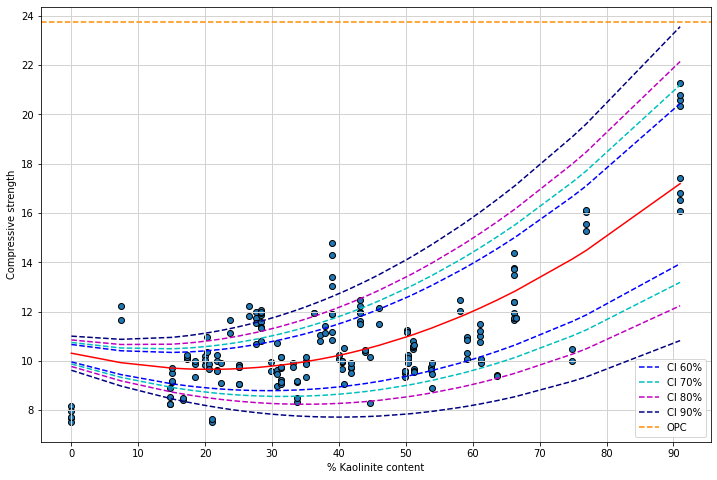

MSE: 2.335067644384823
R^2: 0.5802361848393611



In [23]:
plot_confidence_intervals(get_model_data_kaolinite(data_full_clay, 'day_1'), 1)

f(x) = 21.499593836099116 + -0.07517428017416196*x + 0.003217313075448539*x^2


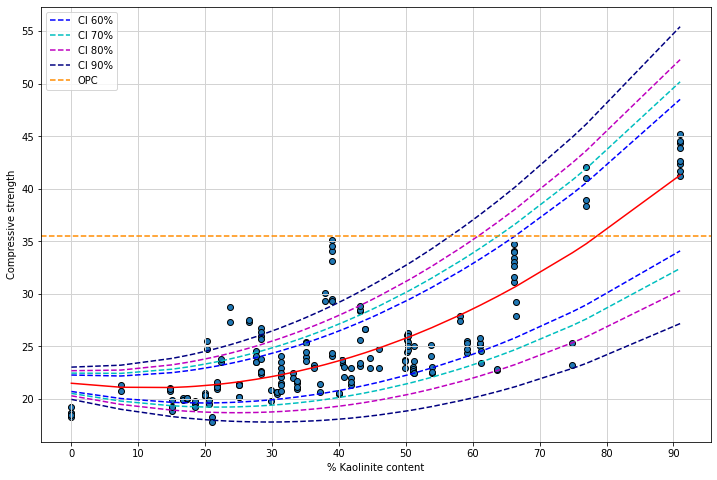

MSE: 11.161599829779187
R^2: 0.6761941738185395



In [24]:
plot_confidence_intervals(get_model_data_kaolinite(data_full_clay, 'day_3'), 3)

f(x) = 24.622228848517352 + 0.3633448897361749*x + -0.0006406772264531545*x^2


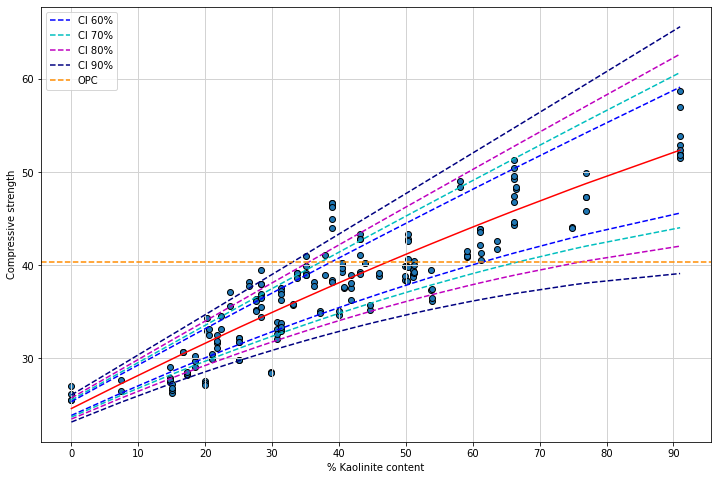

MSE: 9.199436032207917
R^2: 0.8046818970628405



In [25]:
plot_confidence_intervals(get_model_data_kaolinite(data_full_clay, 'day_7'), 7)

f(x) = 27.50212069942936 + 0.6708050880810262*x + -0.0033879531411116952*x^2


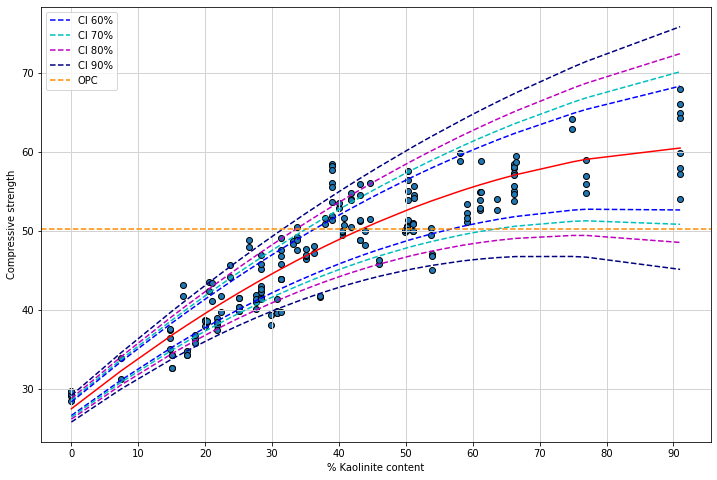

MSE: 12.368760880897872
R^2: 0.8195507057666824



In [26]:
plot_confidence_intervals(get_model_data_kaolinite(data_full_clay, 'day_28'), 28)

f(x) = 27.49766314037672 + 0.7660694480966869*x + -0.0042039181629024164*x^2


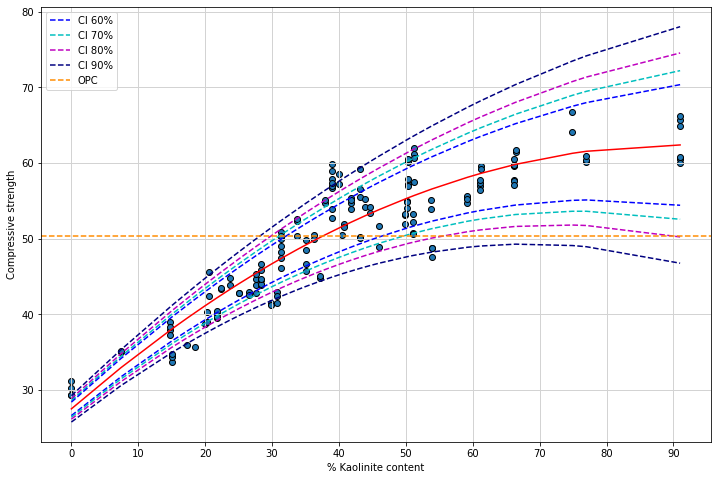

MSE: 11.407070054088853
R^2: 0.8500509643195537



In [27]:
plot_confidence_intervals(get_model_data_kaolinite(data_full_clay, 'day_90'), 90)

#### Toy example for putting things into practice

We are going to start with the Kaolinite content based model for compression strength at day 90 to exemplify the tools and techniques we can use to estimate confidence intervals in our model.

In [35]:
import statsmodels.api as sm
import statsmodels.formula.api as smf

from statsmodels.sandbox.regression.predstd import wls_prediction_std

f(x) = 27.49766314037672 + 0.7660694480966869*x + -0.0042039181629024164*x^2


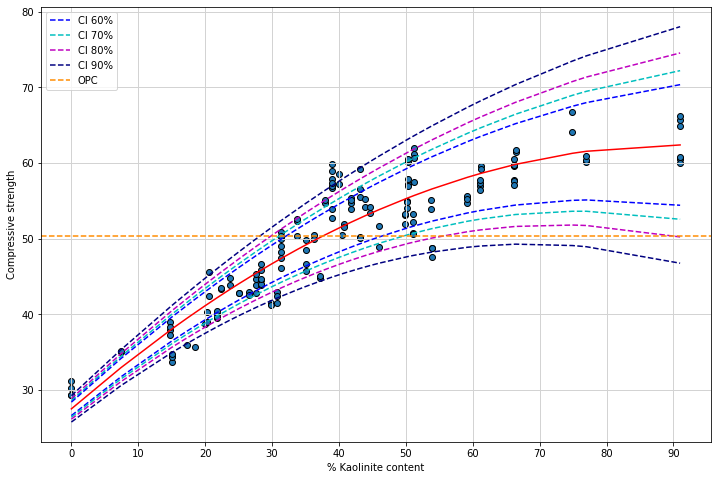

MSE: 11.407070054088853
R^2: 0.8500509643195537



In [22]:
plot_confidence_intervals(get_model_data_kaolinite(data_full_clay, 'day_90'), 90)

In [81]:
prstd, iv_l, iv_u = wls_prediction_std(res)

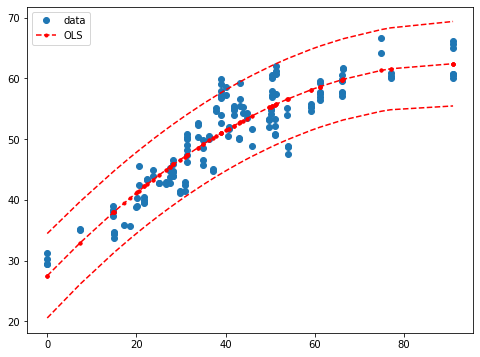

In [82]:
fig, ax = plt.subplots(figsize=(8,6))

ax.plot(x90, y90, 'o', label="data")
#ax.plot(x90, model.predict(x90.reshape(-1,1)), 'b-', label="True")
ax.plot(x90, res.fittedvalues, 'r--.', label="OLS")
ax.plot(x90, iv_u, 'r--')
ax.plot(x90, iv_l, 'r--')
ax.legend(loc='best')

f(x) = 27.50212069942936 + 0.6708050880810262*x + -0.0033879531411116952*x^2


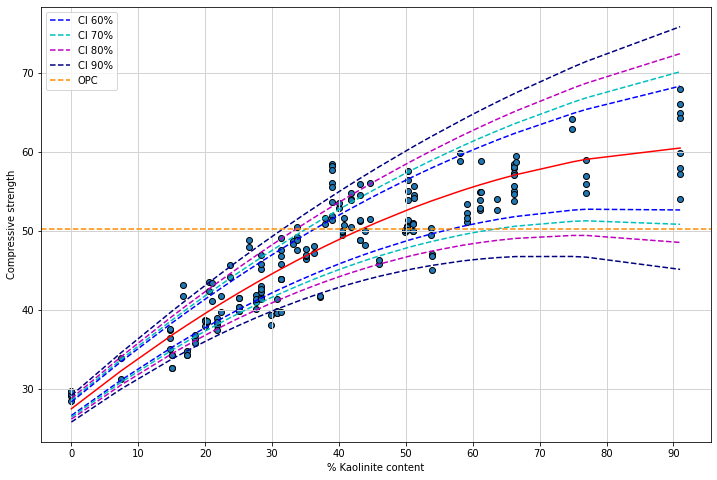

MSE: 12.368760880897872
R^2: 0.8195507057666824



In [38]:
plot_confidence_intervals(get_model_data_kaolinite(data_full_clay, 'day_28'), 28)

In [42]:
prstd, iv_l, iv_u = wls_prediction_std(res)

ValueError: x and y must have same first dimension, but have shapes (184,) and (152,)

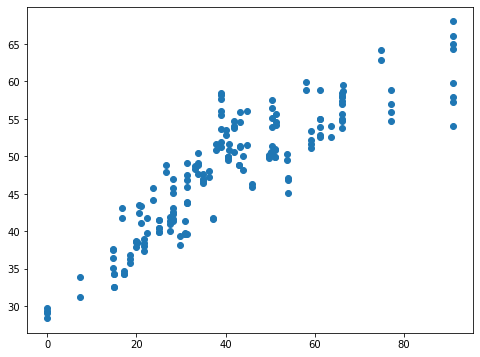

In [43]:
fig, ax = plt.subplots(figsize=(8,6))

ax.plot(x28, y28, 'o', label="data")
#ax.plot(x90, model.predict(x90.reshape(-1,1)), 'b-', label="True")
ax.plot(x28, res.fittedvalues, 'r--.', label="OLS")
ax.plot(x28, iv_u, 'r--')
ax.plot(x28, iv_l, 'r--')
ax.legend(loc='best')

**First sight analysis:**

* We can't afford confidence intervals of such a high precission with such a lack of points, specially for high kaolinite contents.
* However, this worths a try after adding all the points from the second excel!

### Not so toy example, how I would like it to be:

f(x) = 24.622228848517352 + 0.3633448897361749*x + -0.0006406772264531545*x^2


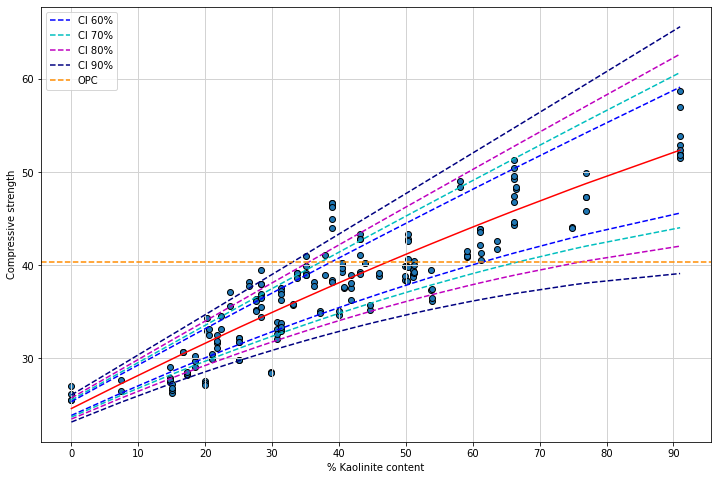

MSE: 9.199436032207917
R^2: 0.8046818970628405



In [37]:
plot_confidence_intervals(get_model_data_kaolinite(data_full_clay, 'day_7'), 7)

f(x) = 24.622228848517352 + 0.3633448897361749*x + -0.0006406772264531545*x^2


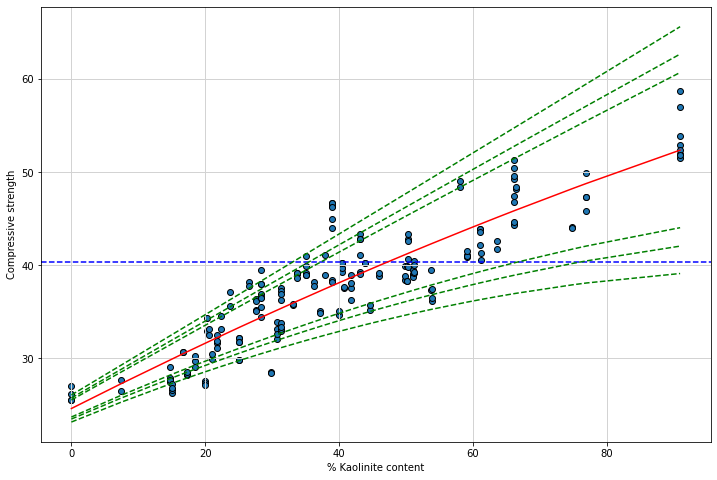

MSE: 9.199436032207917
R^2: 0.8046818970628405



In [46]:
# TODO: Customize!!
# Colors: https://matplotlib.org/3.1.0/gallery/color/named_colors.html
# Grid:   https://matplotlib.org/3.2.1/api/_as_gen/matplotlib.pyplot.grid.html

day = 7
CS_day_7 = 40.38

X = data_7[['Kaolinite_content','Kaolinite_content_square']].values
y = data_7['day_'+str(day)]

res = smf.ols(formula='day_'+str(day)+' ~ Kaolinite_content + Kaolinite_content_square', data=data_7).fit()

conf90 = res.conf_int(alpha=0.1)
conf80 = res.conf_int(alpha=0.2)
conf70 = res.conf_int(alpha=0.3)

# This could be generalized but degree n >= 3 leads to overfitting!
print('f(x) = {0} + {1}*x + {2}*x^2'.format(res.params[0],res.params[1],res.params[2]))
    
# Get the list of predictions obtained while validating
model = LinearRegression()
model.fit(X,y)

predicted = cross_val_predict(model, X, y, cv=LeaveOneOut())

# Plot the results
fig, ax = plt.subplots(figsize=(12, 8))

plt.axhline(y = CS_day_7, color = 'b', linestyle = '--') # OPC reference
plt.grid(color='lightgrey', linestyle='-', linewidth=1)  # Grid

ax.scatter(X[:,0], y, edgecolors=(0, 0, 0))

ax.plot(X[:,0], np.dot(X,[conf70[0][1],conf70[0][2]]) + conf70[0][0],'g--')
ax.plot(X[:,0], np.dot(X,[conf80[0][1],conf80[0][2]]) + conf80[0][0],'g--')
ax.plot(X[:,0], np.dot(X,[conf90[0][1],conf90[0][2]]) + conf90[0][0],'g--')
ax.plot(X[:,0], np.dot(X,model.coef_) + model.intercept_,'r-')
ax.plot(X[:,0], np.dot(X,[conf90[1][1],conf90[1][2]]) + conf90[1][0],'g--')
ax.plot(X[:,0], np.dot(X,[conf80[1][1],conf80[1][2]]) + conf80[1][0],'g--')
ax.plot(X[:,0], np.dot(X,[conf70[1][1],conf70[1][2]]) + conf70[1][0],'g--')

ax.set_xlabel('% Kaolinite content')
ax.set_ylabel('Compressive strength')
plt.show()

# Metrics for the model
print("MSE: {}".format(mean_squared_error(y, predicted)))
print("R^2: {}".format(model.score(X,y)))
print()

### References:

* How to deal with small datasets:\
https://medium.com/rants-on-machine-learning/what-to-do-with-small-data-d253254d1a89

* Feature engineering: \
https://machinelearningmastery.com/discover-feature-engineering-how-to-engineer-features-and-how-to-get-good-at-it/

* Feature selection: \
https://en.wikipedia.org/wiki/Feature_selection \
https://machinelearningmastery.com/an-introduction-to-feature-selection/ \
https://machinelearningmastery.com/feature-selection-machine-learning-python/ \
https://machinelearningmastery.com/feature-selection-in-python-with-scikit-learn/ \
https://machinelearningmastery.com/calculate-feature-importance-with-python/

* Linear regression with python: \
https://realpython.com/linear-regression-in-python/ 

* Confidence estimation: \
https://www.puneetarora2000.com/2020/01/data-interpretation-understanding-ols.html \
https://medium.com/@jyotiyadav99111/statistics-how-should-i-interpret-results-of-ols-3bde1ebeec01 \
https://www.statsmodels.org/stable/regression.html \

